In [2]:
import torch
from torch import optim, nn
from math import exp

import numpy as np

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image
from auto_encoder2 import PAutoE

from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)

In [2]:
T = 100
beta = torch.linspace(10e-4, 0.02, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_

tensor([0.9990, 0.9978, 0.9964, 0.9949, 0.9931, 0.9912, 0.9890, 0.9867, 0.9842,
        0.9815, 0.9787, 0.9756, 0.9724, 0.9690, 0.9654, 0.9617, 0.9578, 0.9537,
        0.9494, 0.9450, 0.9404, 0.9357, 0.9308, 0.9258, 0.9206, 0.9153, 0.9098,
        0.9041, 0.8984, 0.8925, 0.8865, 0.8803, 0.8740, 0.8676, 0.8611, 0.8544,
        0.8477, 0.8408, 0.8338, 0.8268, 0.8196, 0.8123, 0.8050, 0.7975, 0.7900,
        0.7824, 0.7747, 0.7669, 0.7591, 0.7512, 0.7432, 0.7352, 0.7271, 0.7190,
        0.7108, 0.7026, 0.6944, 0.6861, 0.6778, 0.6694, 0.6610, 0.6526, 0.6442,
        0.6358, 0.6273, 0.6189, 0.6104, 0.6020, 0.5935, 0.5850, 0.5766, 0.5682,
        0.5597, 0.5513, 0.5430, 0.5346, 0.5263, 0.5180, 0.5097, 0.5015, 0.4933,
        0.4851, 0.4770, 0.4689, 0.4609, 0.4529, 0.4450, 0.4371, 0.4293, 0.4215,
        0.4138, 0.4062, 0.3986, 0.3911, 0.3836, 0.3763, 0.3689, 0.3617, 0.3545,
        0.3475], device='cuda:0')

In [3]:
model = PAutoE(3, 3).to(device)

In [4]:
def ssim_loss(pred, target):
    mean_pred = torch.mean(pred)
    mean_target = torch.mean(target)

    var_pred = torch.var(pred)
    var_target = torch.var(target)

    cov = torch.mean(pred * target) - mean_pred * mean_target

    c1 = 0.01 ** 2
    c2 = 0.03 ** 2

    ssim = (2 * mean_pred * mean_target + c1) * (2 * cov + c2) 
    ssim /= (mean_pred ** 2 + mean_target ** 2 + c1) * (var_pred + var_target + c2)

    return 1 - ssim

In [5]:
mse = nn.MSELoss()
#mse = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = lambda pred, target: mse(pred, target) + 2*ssim_loss(pred, target)

  0%|          | 0/200001 [00:00<?, ?it/s]

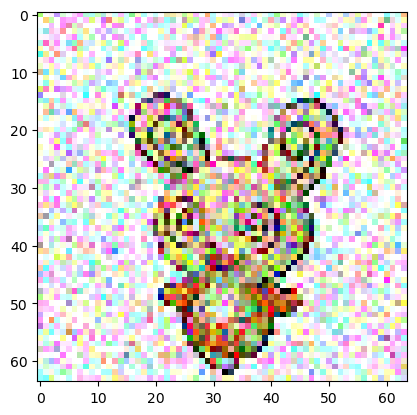

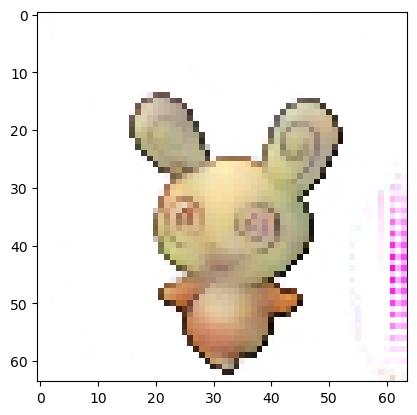

0.14424677:   0%|          | 500/200001 [00:14<1:35:03, 34.98it/s]

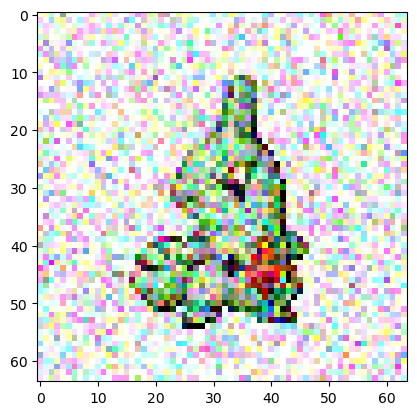

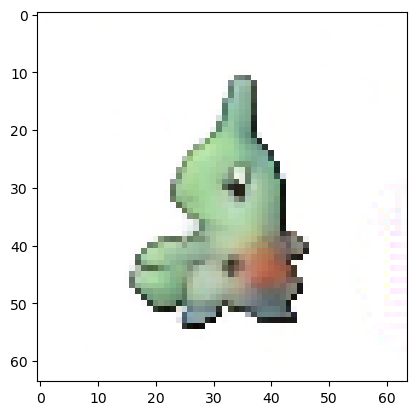

0.18265496:   0%|          | 1000/200001 [00:29<1:35:45, 34.63it/s]

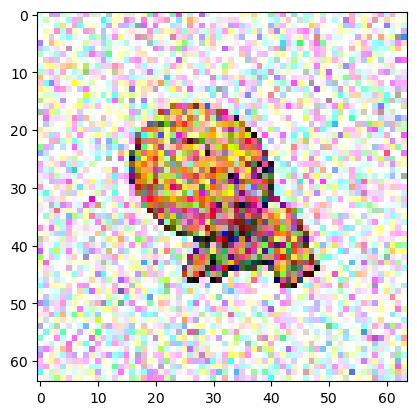

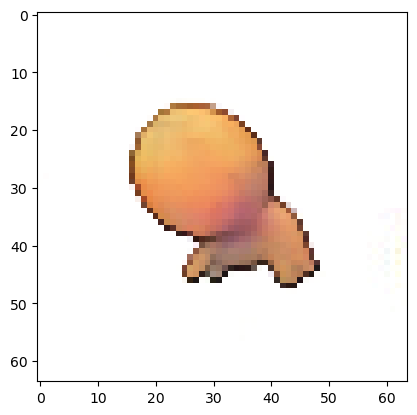

0.15886067:   1%|          | 1261/200001 [00:37<1:37:12, 34.07it/s]


KeyboardInterrupt: 

In [8]:
pbar = tqdm(range(200001), miniters=5)
def closure2():
    optimizer.zero_grad()

    source = randint(0, 2)
    batch = torch.randperm(385)[:8]
    color = torch.randperm(3)
    
    x0 = pimages[source, batch][color]
    e = torch.randn(x0.shape, device=device)

    t = randint(0, T - 1)
    
    x_nois = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * e
    e_pred = model(x_nois, t)

    # Calculate the loss between the result and the noise
    loss = loss_func(e, e_pred)
    loss.backward()
    
    pbar.set_description(f"t = {t}, %.8f" % loss, refresh=False)
    
    return loss

def closure():
    optimizer.zero_grad()

    source = randint(0, 2)
    batch = torch.randperm(385)[:16]
    color = torch.randperm(3)
    
    x0 = pimages[source, batch][color]
    noise = torch.randn(x0.shape, device=device)
    
    pred = model(x0 + noise, 0)

    # Calculate the loss between the result and the noise
    loss = loss_func(x0, pred)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss


model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 500 == 0:
        model.eval()
        with torch.no_grad():
            source = randint(0, 2)
            batch = torch.randperm(385)[:8]
            color = torch.randperm(3)

            x0 = pimages[source, batch][color]
            noise = torch.randn(x0.shape, device=device) * 0.5

            pred = model(x0 + noise, 0)

            plot_image((x0 + noise)[0])
            plot_image(pred[0])

        model.train()

In [ ]:
import math

def positionalencoding1d(d_model, length):
    
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe


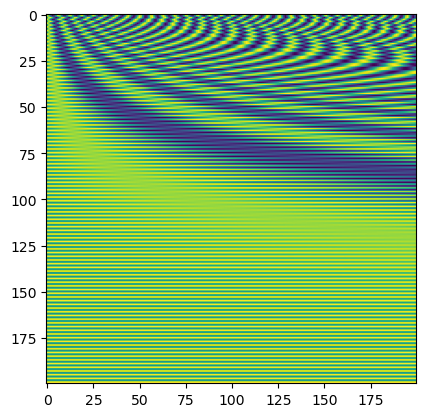

In [ ]:
a = positionalencoding1d(200, 200)

plt.imshow(a.transpose(0, 1))